In [272]:
import numpy as np
import sklearn.datasets
import time
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from tqdm import tqdm


In [273]:
def V_1(X):
    n = X.shape[0]

    X = np.sort(X)
    s = np.std(X)

    tmp_1 = True
    tmp_2 = True

    V_array = np.array([])


    for m in range(1, int(n/2)):

        product = 1


        for i in range(1, n + 1):

            if i - m <= 1:
                X_1 = X[0]
                tmp_1 = False

            if i + m >= n:
                X_2 = X[-1]
                tmp_2 = False


            if tmp_1:
                X_1 = X[i - m - 1]

            if tmp_2:
                X_2 = X[i + m - 1]

            tmp_1 = True
            tmp_2 = True
                
            product *= 1 / (X_2 - X_1)


        V = (2 * np.pi * np.e * s**2)**(n / 2) * (2 * m / n) ** n * product 

        V_array = np.append(V_array, V)


    return V_array

In [274]:
def calculate_inner_product(X, m):
    n = X.shape[0]
    p = 1
    for i in range(n):
        i_plus_m = min(i + m, n - 1)
        i_minus_m = max(i - m, 0)
        p /= (X[i_plus_m] - X[i_minus_m])
    return p * (2 * m / n) ** n

def V_2(X, delta=0.5):
    n = X.shape[0]
    X = np.sort(X)
    s = np.std(X)
    V = np.array([calculate_inner_product(X, m) for m in range(1, int(n ** (1 - delta)))])
    
    return (2 * np.pi * np.e * s**2)**(n / 2) * V
    


In [275]:
def get_c_array(alpha, n_array, N, test=V_1):
    C_array = np.array([])
    for n in tqdm(n_array):
        V_array = np.array([])
        X = np.random.normal(0, 1, size=(N, n))

        for i in range(N):
            V = np.log(np.min(test(X[i])))
            V_array = np.append(V_array, V)


        V_array = np.sort(V_array)
        C = V_array[-int(alpha * N) + 2]
        C_array = np.append(C_array, C)

    return C_array

In [276]:
N = 1000 # number of samples for monte carlo
n_array = np.arange(5, 100, 5, dtype=int) # sample size
alphas = [0.01, 0.025, 0.05, 0.1, 0.125, 0.15, 0.25, 0.3, 0.4, 0.45]

In [277]:
C_arrays_v1 = np.array([get_c_array(alpha, n_array, N, test=V_1) for alpha in alphas])

100%|██████████| 19/19 [00:09<00:00,  2.07it/s]


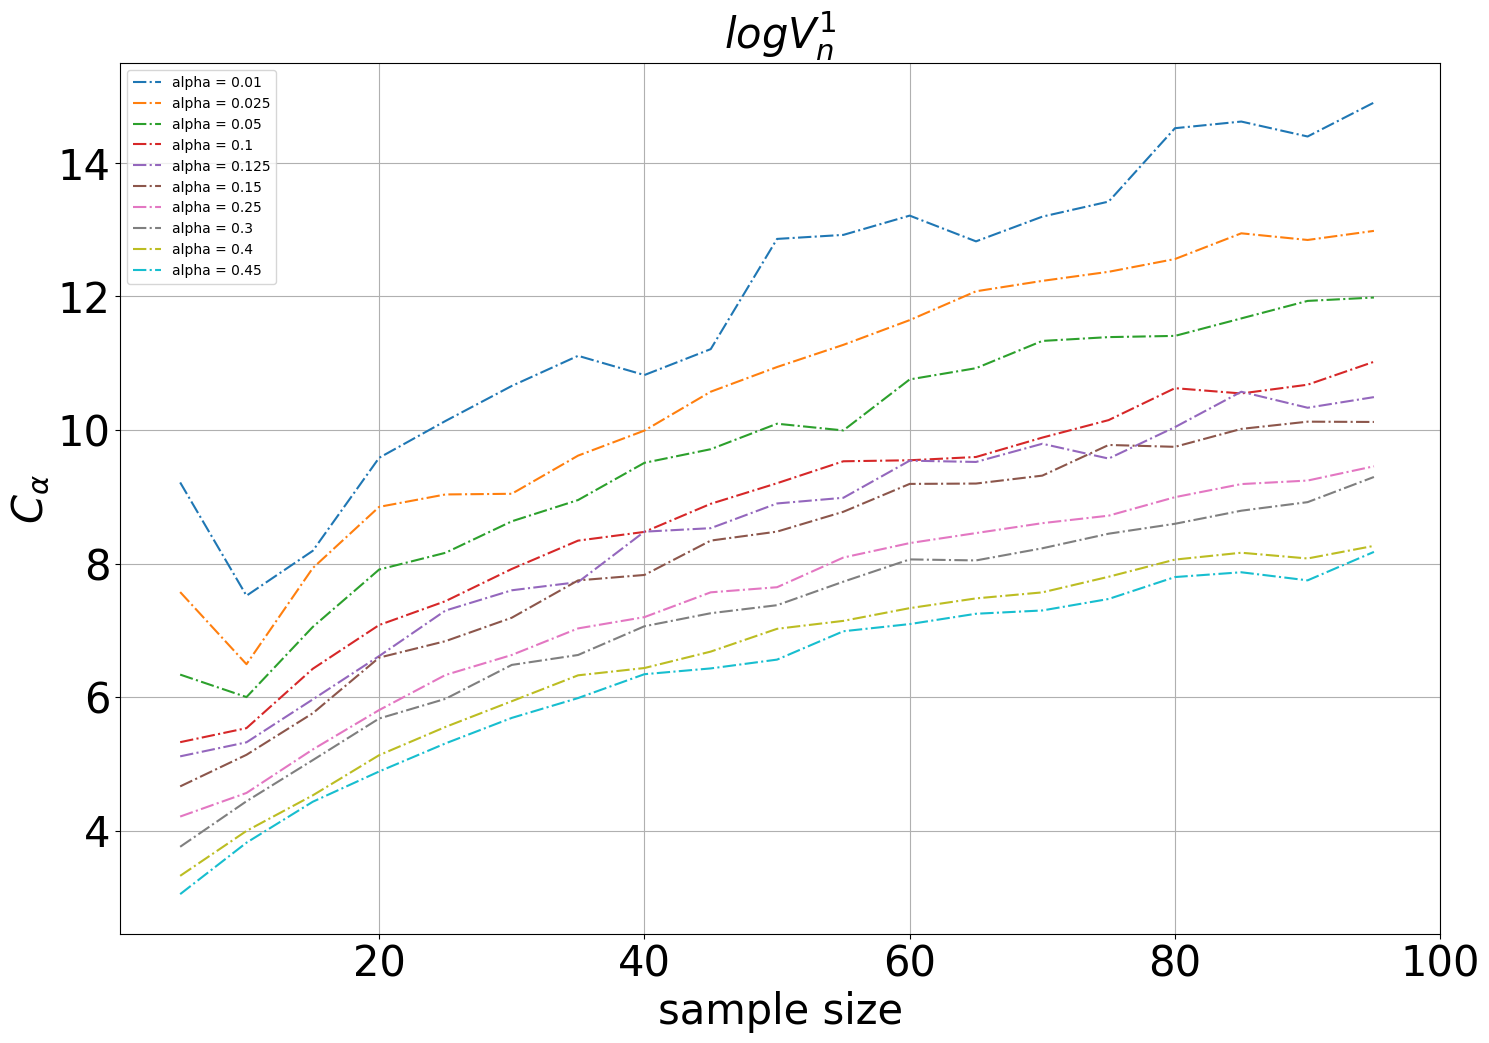

In [278]:
f, ax1 = plt.subplots(1,figsize = (15,10))

# colors = ['black', 'blue'] * 5
# colors[0] = 'red'

for i, C_array in enumerate(C_arrays_v1):
    plt.plot(n_array, C_array, label='alpha = '+str(alphas[i]), ls='dashdot')#, color=colors[i])


ax1.grid(alpha = 1)
ax1.xaxis.set_major_locator(MaxNLocator(integer=False))
ax1.set_xlabel('sample size', fontsize = 30 )
ax1.set_ylabel(r'$C_{\alpha}$', fontsize = 30 )


ax1.legend(fontsize = 10)

ax1.set_xticks(np.arange(20, 101, 20), np.arange(20, 101, 20))
ax1.tick_params(axis='x', labelsize=30)
ax1.tick_params(axis='y', labelsize=30)

plt.tight_layout()

plt.title('$logV_n^1$', fontsize = 30)
plt.show()


In [279]:
C_arrays_v2 = np.array([get_c_array(alpha, n_array, N, test=V_2) for alpha in alphas])

100%|██████████| 19/19 [00:02<00:00,  7.98it/s]


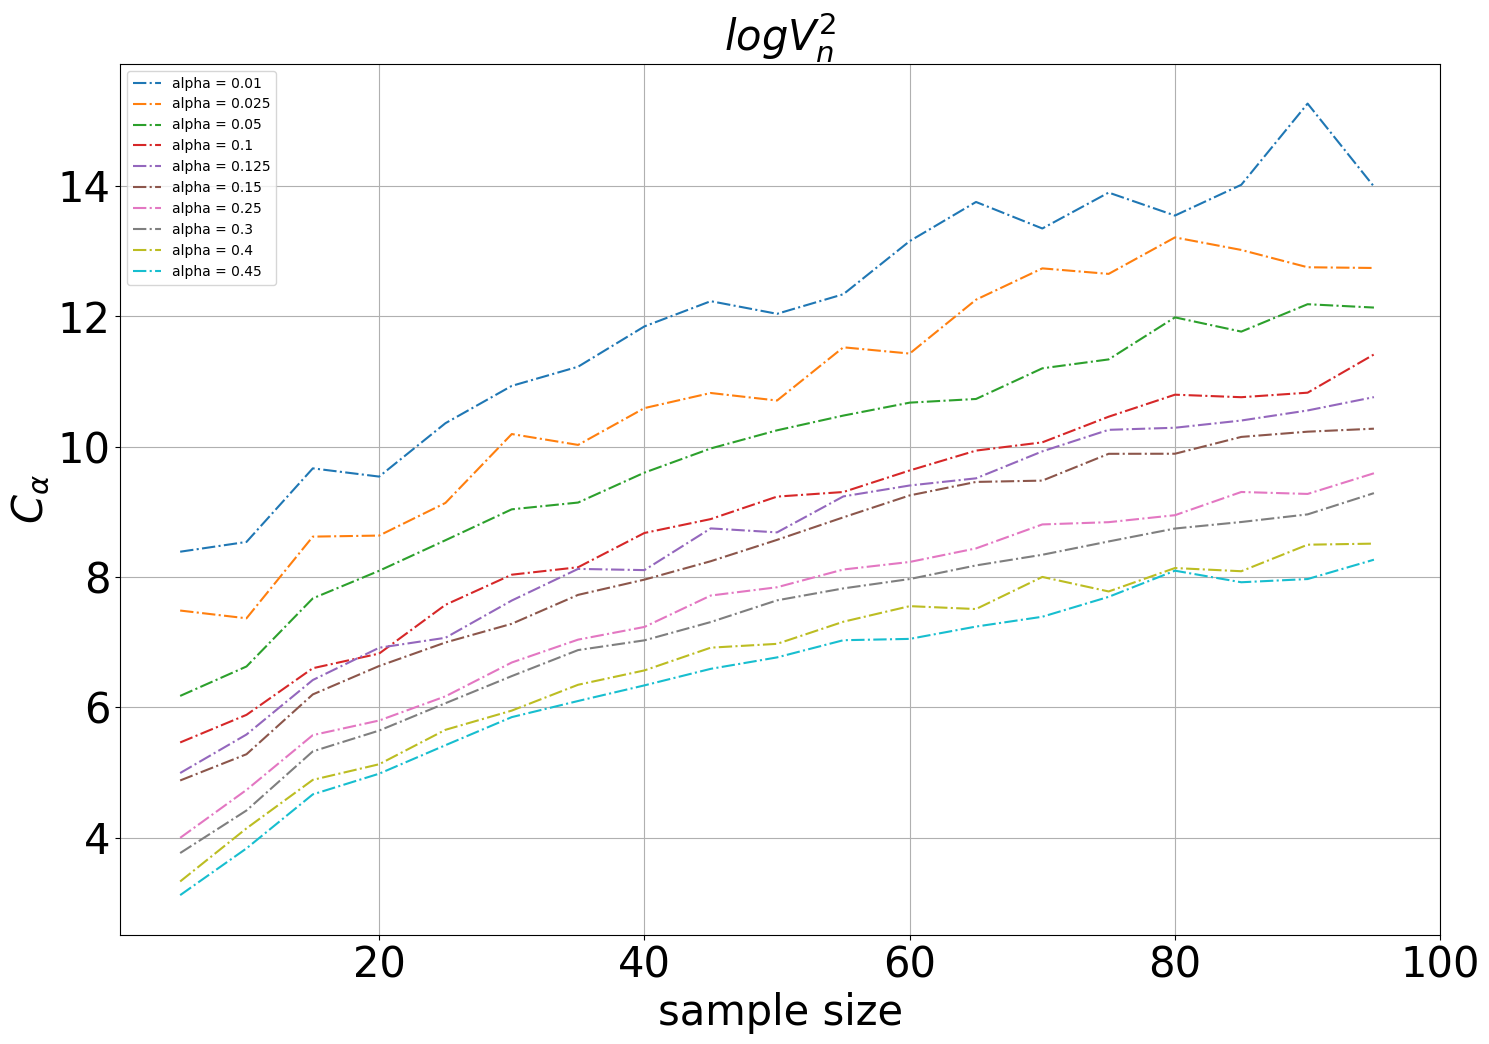

In [280]:
f, ax1 = plt.subplots(1,figsize = (15,10))

# colors = ['black', 'blue'] * 5
# colors[0] = 'red'

for i, C_array in enumerate(C_arrays_v2):
    plt.plot(n_array, C_array, label='alpha = '+str(alphas[i]), ls='dashdot')#, color=colors[i])


ax1.grid(alpha = 1)
ax1.xaxis.set_major_locator(MaxNLocator(integer=False))
ax1.set_xlabel('sample size', fontsize = 30 )
ax1.set_ylabel(r'$C_{\alpha}$', fontsize = 30 )


ax1.legend(fontsize = 10)

ax1.set_xticks(np.arange(20, 101, 20), np.arange(20, 101, 20))
ax1.tick_params(axis='x', labelsize=30)
ax1.tick_params(axis='y', labelsize=30)

plt.tight_layout()

plt.title('$logV_n^2$', fontsize = 30)
plt.show()


### Explore power of the test

In [281]:
indexes = [3, 9, 13]
alpha_index= 2
n_array[indexes], alphas[alpha_index]

(array([20, 50, 70]), 0.05)

In [282]:
C20, C50, C70 = np.exp(C_arrays_v1[alpha_index][indexes]) # thresholds for statistics
C_dict = {20: C20, 50: C50, 70: C70}

In [283]:
from collections import defaultdict
from scipy.stats import shapiro
import pandas as pd

In [284]:
v1_pows = defaultdict(list)
v2_pows = defaultdict(list)
w_pows = defaultdict(list)

In [285]:
distrs = {
    'Exp': [np.random.exponential, [1]],
    'Gamma': [np.random.gamma, [2, 1]],
    'Unif': [np.random.uniform, [0, 1]],
    'Beta': [np.random.beta, [2, 1]],
    'Cauchy': [np.random.standard_cauchy, []],
    }

In [286]:
n_mc = 1000
for key in tqdm(distrs.keys()):
    for sample_size in [20, 50, 70]:
        func, params = distrs[key]
        samples = func(*params, (n_mc, sample_size))
        pow_v1 = (np.array([(V_1(samples[i]) < C_dict[sample_size]).sum() / sample_size for i in range(n_mc)]) < 0.05).sum() / n_mc
        pow_v2 = (np.array([(V_2(samples[i]) < C_dict[sample_size]).sum() / sample_size for i in range(n_mc)]) < 0.05).sum() / n_mc
        pow_shapiro = (np.array([shapiro(samples[i]) for i in range(n_mc)]) < 0.05).sum() / n_mc
        v1_pows[key].append(pow_v1)
        v2_pows[key].append(pow_v2)
        w_pows[key].append(pow_shapiro)

 80%|████████  | 4/5 [00:06<00:01,  1.70s/it]C:\Users\ptmeg\AppData\Local\Temp\ipykernel_13720\76704593.py:41: RuntimeWarning: overflow encountered in scalar power
  V = (2 * np.pi * np.e * s**2)**(n / 2) * (2 * m / n) ** n * product
C:\Users\ptmeg\AppData\Local\Temp\ipykernel_13720\3031686726.py:16: RuntimeWarning: overflow encountered in scalar power
  return (2 * np.pi * np.e * s**2)**(n / 2) * V
100%|██████████| 5/5 [00:08<00:00,  1.69s/it]


In [287]:
dfs = {key: pd.DataFrame(columns=['V1', 'V2', 'W']) for key in [20, 50, 70]}
for i, key in enumerate([20, 50, 70]):
    dfs[key]['V1'] = pd.DataFrame(v1_pows).iloc[i]
    dfs[key]['V2'] = pd.DataFrame(v2_pows).iloc[i]
    dfs[key]['W'] = pd.DataFrame(w_pows).iloc[i]

In [288]:
dfs[20], dfs[50], dfs[70]

(           V1     V2      W
 Exp     0.835  0.847  0.837
 Gamma   0.429  0.445  0.520
 Unif    0.391  0.420  0.197
 Beta    0.416  0.440  0.322
 Cauchy  0.469  0.740  0.863,
            V1     V2      W
 Exp     1.000  1.000  1.000
 Gamma   0.929  0.938  0.947
 Unif    0.959  0.960  0.755
 Beta    0.958  0.959  0.832
 Cauchy  0.443  0.992  0.998,
            V1     V2      W
 Exp     1.000  1.000  1.000
 Gamma   0.987  0.991  0.993
 Unif    0.995  0.996  0.933
 Beta    0.996  0.996  0.965
 Cauchy  0.359  0.999  1.000)